In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pdb
from collections import deque
%matplotlib inline

In [2]:
# helper functions

In [3]:
def bottomHistogram(img):
    bottom_half = img[img.shape[0]//2:, :]
    hist = np.sum(bottom_half, axis=0)
    return hist

def getTwoPeaks(histogram):
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def getWindow(x_center, y_center, window_width=200, window_height=80):
    top = y_center - window_height / 2
    bottom = y_center + window_height / 2
    left = x_center - window_width / 2
    right = x_center + window_width / 2
    return top, bottom, left, right

In [4]:
def thresh2Binary(inp, thresh_min, thresh_max):
    binary = np.zeros_like(inp)
    binary[(thresh_min <= inp) & (inp <= thresh_max)] = 1
    return binary

def scaledThresh2Binary(inp, thresh_min, thresh_max):
    scaled = np.uint8(inp / np.max(inp) * 255)
    return thresh2Binary(scaled, thresh_min, thresh_max)

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # thresh=(20, 100)
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise "AugumentError"
    return scaledThresh2Binary(sobel, thresh[0], thresh[1])

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # sobel_kernel=9, mag_thresh=(30, 100)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scaledThresh2Binary(magnitude, thresh[0], thresh[1])

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # sobel_kernel=15, thresh=(0.7, 1.3)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    return thresh2Binary(direction, thresh[0], thresh[1])

def hls_thresh(image, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        raise "ArgumentError"
    return thresh2Binary(hls[:,:,c], thresh[0], thresh[1])

def combineBinary(binaryImages = []):
    binary = np.zeros_like(binaryImages[0])
    for bImg in binaryImages:
        binary[bImg == 1] = 1
    return binary

In [5]:
class LaneTracer:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.left_line_coef = None
        self.right_line_coef = None
        
    def getLanePointsGivenLine(self, image_height, image_width, nonzero_x, nonzero_y, line_coef,
                               window_height=80, window_width=200):
        y_center = image_height - window_height / 2
        x_center = np.polyval(line_coef, y_center)
        top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)

        in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        current_in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        while y_center >= 0 and x_center >= 0 and x_center <= image_width:
            current_in_indexes |= (
                (left <= nonzero_x) & (nonzero_x <= right) & (top <= nonzero_y) & (nonzero_y <= bottom)
            )
            
            #cv2.rectangle(canvas, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)
            in_indexes |= current_in_indexes
            current_in_indexes.fill(0)
            y_center -= window_height
            x_center = np.polyval(line_coef, y_center)
            top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)

        lane_points = [nonzero_x[in_indexes], nonzero_y[in_indexes]]
        return lane_points
    
    def getLanePointsGivenCenter(self, image_height, image_width, nonzero_x, nonzero_y, x_center, 
                                 window_height=80, window_width=200, n_recenter=50):
        y_center = image_height - window_height / 2
        top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)

        momentum = 0.0
        in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        current_in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
        while y_center >= 0 and x_center >= 0 and x_center <= image_width:
            current_in_indexes |= (
                (left <= nonzero_x) & (nonzero_x <= right) & (top <= nonzero_y) & (nonzero_y <= bottom)
            )
            
            if np.count_nonzero(current_in_indexes) >= n_recenter:
                new_x_center = nonzero_x[current_in_indexes].mean()
                momentum = new_x_center - x_center
                x_center = new_x_center
            else:
                x_center += momentum

            #cv2.rectangle(canvas, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)
            in_indexes |= current_in_indexes
            current_in_indexes.fill(0)
            y_center -= window_height
            top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)

        lane_points = [nonzero_x[in_indexes], nonzero_y[in_indexes]]
        return lane_points
    
    def process2Binary(self, image):
        image_binary = []
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_binary.append(abs_sobel_thresh(gray, 'x', 15, (60, 200)))
        #image_binary.append(abs_sobel_thresh(gray, 'y', 15, (100, 150)))
        image_binary.append(cv2.Canny(gray, 50, 150))
        image_binary.append(hls_thresh(image, 'h', (20, 40)))
        image_binary.append(hls_thresh(image, 'l', (250, 255)))
        image_binary.append(dir_thresh(gray, 3, (0.7, 0.75)))
        combined = combineBinary(image_binary)
        return combined
    
    def getLanePointsByHist(self, image_binary):
        histogram = bottomHistogram(image_binary)
        left_center, right_center = getTwoPeaks(histogram)
        
        nonzero = image_binary.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        if self.left_line_coef is not None and self.right_line_coef is not None:
            left_lane_points = self.getLanePointsGivenLine(image_binary.shape[0], image_binary.shape[1], 
                                                           nonzero_x, nonzero_y, self.left_line_coef)
            right_lane_points = self.getLanePointsGivenLine(image_binary.shape[0], image_binary.shape[1], 
                                                            nonzero_x, nonzero_y, self.right_line_coef)
        else:
            left_lane_points = self.getLanePointsGivenCenter(image_binary.shape[0], image_binary.shape[1], 
                                                             nonzero_x, nonzero_y, left_center)
            right_lane_points = self.getLanePointsGivenCenter(image_binary.shape[0], image_binary.shape[1], 
                                                              nonzero_x, nonzero_y, right_center)
        return left_lane_points, right_lane_points
    
    def getLeftFitLinePoints(self, x_points, y_points, y_upper, fit_degree):
        line_coef = np.polyfit(y_points, x_points, fit_degree)
        if self.left_line_coef is not None:
            self.left_line_coef += (line_coef - self.left_line_coef) * 0.035
        else:
            self.left_line_coef = line_coef
        y_steps = np.linspace(0, y_upper-1, y_upper)
        x_fit = np.polyval(self.left_line_coef, y_steps)
        return x_fit, y_steps
    
    def getRightFitLinePoints(self, x_points, y_points, y_upper, fit_degree):
        line_coef = np.polyfit(y_points, x_points, fit_degree)
        if self.right_line_coef is not None:
            self.right_line_coef += (line_coef - self.right_line_coef) * 0.035
        else:
            self.right_line_coef = line_coef
        y_steps = np.linspace(0, y_upper-1, y_upper)
        x_fit = np.polyval(self.right_line_coef, y_steps)
        return x_fit, y_steps

    def removeOutsidePoints(self, x_points, y_points, x_upper):
        pick = (0 <= x_points) & (x_points <= x_upper)
        y_points = y_points[pick]
        x_points = x_points[pick]
        return x_points, y_points

    def drawFitLane(self, canvas, left_points, right_points, fit_degree):
        left_x_fit, left_y_steps = self.getLeftFitLinePoints(left_points[0], left_points[1], 
                                                             canvas.shape[0], fit_degree)
        left_x_fit, left_y_steps = self.removeOutsidePoints(left_x_fit, left_y_steps, canvas.shape[1])
        
        right_x_fit, right_y_steps = self.getRightFitLinePoints(right_points[0], right_points[1], 
                                                                canvas.shape[0], fit_degree)
        right_x_fit, right_y_steps = self.removeOutsidePoints(right_x_fit, right_y_steps, canvas.shape[1])
        
        left_points = np.dstack((left_x_fit, left_y_steps)).reshape((-1, 1, 2))
        right_points = np.dstack((right_x_fit, right_y_steps)).reshape((-1, 1, 2))
        points = np.concatenate((left_points, right_points[::-1]))

        cv2.fillPoly(canvas, [points.astype(int)], (0, 255, 0))
            
    def getLanePlane(self, image_birdeye):
        image_binary = self.process2Binary(image_birdeye)
        plt.figure()
        plt.title('binary')
        plt.imshow(image_binary, cmap='gray')
        cv2.imwrite('single_image_demo/binary.jpg', np.dstack((image_binary, image_binary, image_binary))*255)
        
        left_lane_points, right_lane_points = self.getLanePointsByHist(image_binary)
        
        lane_plane = np.zeros_like(image_birdeye)
        self.drawFitLane(lane_plane, left_lane_points, right_lane_points, 2)
        return lane_plane

In [6]:
class AdvancedLaneFinder:
    def __init__(self, chessboard_image_dir, nx=9, ny=6, src=None, dst=None):
        self.mtx, self.dist = self.calibrateCamera(chessboard_image_dir, nx, ny)
        self.M, self.Minv = self.getPerspectiveMatrix(src, dst)
        self.lane_tracer = LaneTracer()
        
    def resetLaneTracer(self):
        self.lane_tracer.reset()
        
    def calibrateCamera(self, chessboard_image_dir, nx, ny):
        image_points = []
        object_points = []
        mapped_corners = np.zeros([nx * ny, 3], np.float32)
        mapped_corners[:,:2] = np.mgrid[:nx, :ny].T.reshape([-1, 2])

        chessboard_image_paths = glob.glob(os.path.join(chessboard_image_dir, "*"))
        for chessboard_image_path in chessboard_image_paths:
            chessboard_image = cv2.imread(chessboard_image_path)
            gray_chessboard_image = cv2.cvtColor(chessboard_image, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray_chessboard_image, (nx, ny), None)
            if ret:
                object_points.append(mapped_corners)
                image_points.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, chessboard_image.shape[1::-1], None, None)
        return mtx, dist

    def getPerspectiveMatrix(self, src=None, dst=None):
        if src is None:
            src = np.float32([[300, 675], [1030, 675], [700, 456], [585, 456]])
            dst = np.float32([[300, 720], [1030, 720], [1030, 200], [300, 200]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        return M, Minv
    
    def drawLaneVideo(self, video_path):
        pass
        
    def drawLaneImage(self, image):
        plt.figure()
        plt.title('original')
        plt.imshow(image[:,:,::-1])
        cv2.imwrite('single_image_demo/original.jpg', image)
        
        image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        plt.figure()
        plt.title('undistorted')
        plt.imshow(image[:,:,::-1])
        cv2.imwrite('single_image_demo/undistorted.jpg', image)
        
        image_birdeye = cv2.warpPerspective(image, self.M, image.shape[1::-1], cv2.INTER_CUBIC)
        plt.figure()
        plt.title('warped')
        plt.imshow(image_birdeye[:,:,::-1])
        cv2.imwrite('single_image_demo/warped.jpg', image_birdeye)
        
        lane_birdeye = self.lane_tracer.getLanePlane(image_birdeye)
        plt.figure()
        plt.title('lane_warped')
        plt.imshow(lane_birdeye[:,:,::-1])
        cv2.imwrite('single_image_demo/lane.jpg', lane_birdeye)
        
        
        lane = cv2.warpPerspective(lane_birdeye, self.Minv, lane_birdeye.shape[1::-1], cv2.INTER_CUBIC)
        plt.figure()
        plt.title('lane')
        plt.imshow(lane[:,:,::-1])
        cv2.imwrite('single_image_demo/lane_warped_back.jpg', lane)
        
        
        image_lane = cv2.addWeighted(image, 1, lane, 0.5, 0)
        plt.figure()
        plt.title('image_with_lane')
        plt.imshow(image_lane[:,:,::-1])
        cv2.imwrite('single_image_demo/image_with_lane.jpg', image_lane)
        
        return image_lane

In [7]:
lane_finder = AdvancedLaneFinder(chessboard_image_dir='./camera_cal', nx=9, ny=6, src=None, dst=None)

True

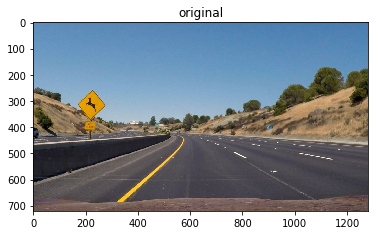

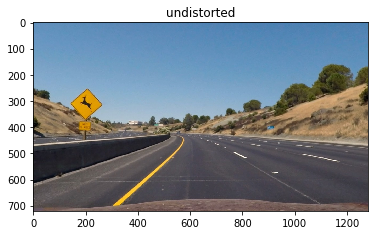

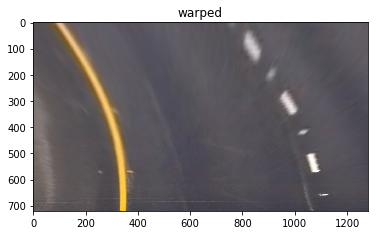

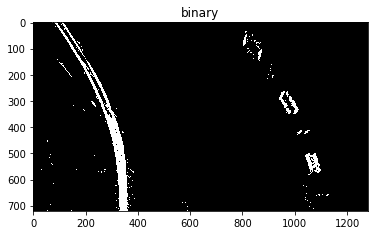

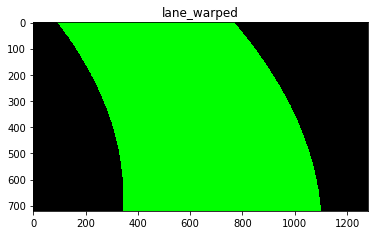

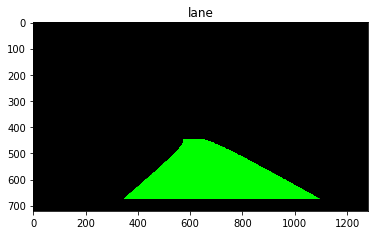

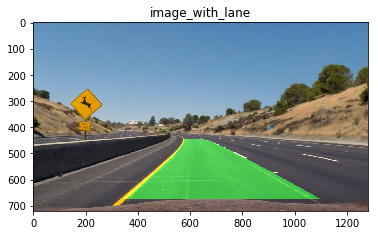

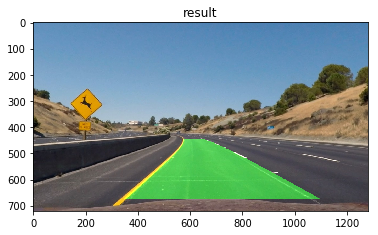

In [8]:
lane_finder.resetLaneTracer()
image = cv2.imread('./test_images/test2.jpg')
image = lane_finder.drawLaneImage(image)
plt.figure()
plt.title('result')
plt.imshow(image[:,:,::-1])
cv2.imwrite('single_image_demo/result.jpg', image)